In [ ]:
#%%capture
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### **Dataset Schema：**
id: Identification number for the flight

dep_stn: Departure airport

arr_stn: Arrival airport

ac_code: Aircraft code

dep_date:S Scheduled departure datetime

arr_date: Scheduled arrival datatime

weather: Observed weather conditions at departure

hobbs_meter: The time in hours that an aircraft has been in use

year_man: Year of manufacturing for the aircraft

dep_country: Departure country

arr_country: Destination country

delay: Number of minutes this flight was delayed


In [ ]:
# import the dataset
train_df = pd.read_csv('train.csv')

# view the dataset's shape
train_df.shape

(20, 8)

In [ ]:
# examine the column types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20 non-null     int64 
 1   dep_stn      20 non-null     object
 2   arr_stn      20 non-null     object
 3   ac_code      20 non-null     int64 
 4   weather      20 non-null     object
 5   hobbs_meter  20 non-null     int64 
 6   year_man     20 non-null     int64 
 7   delay        20 non-null     int64 
dtypes: int64(5), object(3)
memory usage: 1.4+ KB


In [ ]:
# check for nulls in each column
train_df.isnull().sum()

id             0
dep_stn        0
arr_stn        0
ac_code        0
weather        0
hobbs_meter    0
year_man       0
delay          0
dtype: int64

In [ ]:
# view the statistics of continuous variables
train_df.describe()

,id,ac_code,hobbs_meter,year_man,delay
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,10.50000,754.000000,539.750000,3.550000,43.500000
std,5.91608,17.800059,165.613969,0.825578,28.049768
min,1.00000,737.000000,241.000000,2.000000,5.000000
25%,5.75000,737.000000,422.000000,3.000000,21.500000
50%,10.50000,747.000000,523.500000,4.000000,39.000000
75%,15.25000,777.000000,636.000000,4.000000,58.750000
max,20.00000,777.000000,890.000000,5.000000,119.000000


In [ ]:
train_df.head(3)

,id,dep_stn,arr_stn,ac_code,weather,hobbs_meter,year_man,delay
0,1,CDC,Sydney,747,Rain,614,3,31
1,2,NJ,NY,777,Sunny,382,5,22
2,3,BJ,Seoul,777,Cloudy,512,2,61


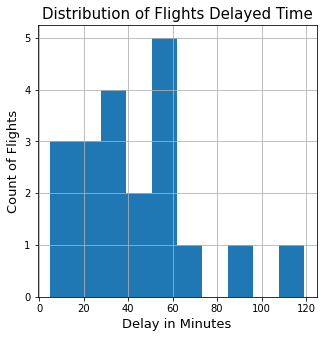

In [ ]:
# Visualize the Distribution of delay
train_df['delay'].hist(figsize=(5,5))
plt.title('Distribution of Flights Delayed Time', size=15)
plt.xlabel('Delay in Minutes',size=13)
plt.ylabel('Count of Flights',size=13)
plt.show()

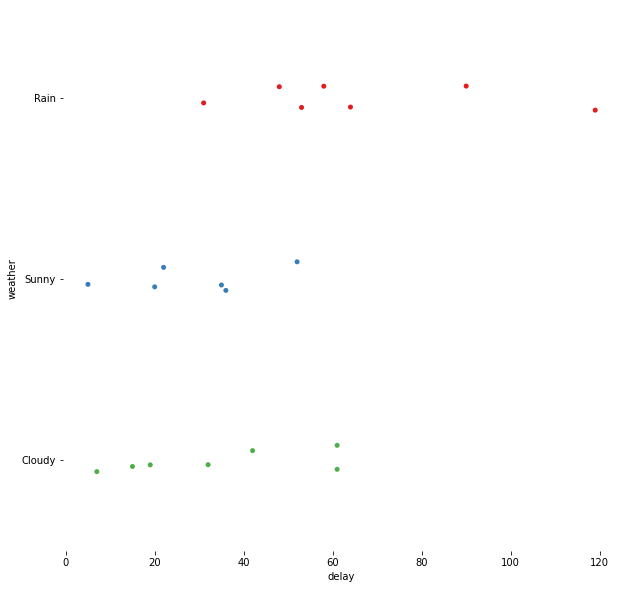

In [ ]:
# visualize the delay time under different weather
axis = plt.subplots(figsize=(10,10))
sns.despine(bottom=True, left=True)
sns.stripplot(x="delay", y="weather",data = train_df, dodge=True, jitter=True,palette="Set1")
plt.show()

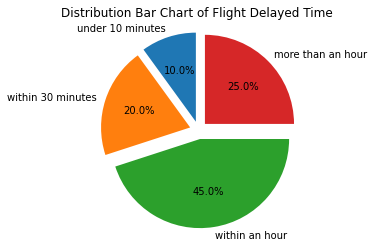

In [ ]:
# 用train data的delay来做pie chart看航班晚到的distribution
a1, a2, a3, a4, i = 0, 0, 0, 0, 0

while i < train_df.shape[0]:
  if train_df['delay'][i] <= 10:
    a1 += 1
    i += 1
  elif train_df['delay'][i] > 10 and train_df['delay'][i] <= 30:
    a2 += 1
    i += 1
  elif train_df['delay'][i] > 30 and train_df['delay'][i] < 60:
    a3 += 1
    i += 1
  else:
    a4 += 1
    i += 1

labels = ['under 10 minutes', 'within 30 minutes', 'within an hour', 'more than an hour']
sizes = [a1, a2, a3, a4]
explode = (0.1, 0.1, 0.1, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
plt.title("Distribution Bar Chart of Flight Delayed Time")
plt.show()

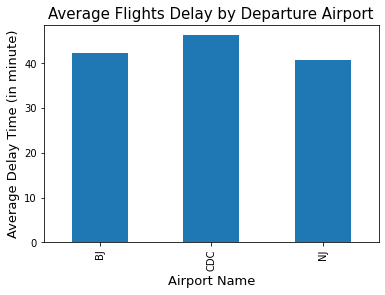

In [ ]:
# calculate the average delay time for each airport (departure airport)
delay_by_airport = train_df.groupby(by='dep_stn').mean()['delay']

# Visualize the Distribution of delay for different airports
delay_by_airport.plot(kind='bar')
plt.title('Average Flights Delay by Departure Airport',size=15)
plt.xlabel('Airport Name',size=13)
plt.ylabel('Average Delay Time (in minute)',size=13)
plt.show()

## **Feature Engineering**

#### - 对于文字类variable（比如出发降落机场）要用Label Encoder


In [ ]:
## 重点！！
lst_of_airport1 = train_df.dep_stn.unique().tolist()
lst_of_airport2 = train_df.arr_stn.unique().tolist()

full_apt_lst = set(lst_of_airport1 + lst_of_airport2)
apt_to_id = {apt:i for i, apt in enumerate(full_apt_lst)}
apt_to_id

{'Sydney': 0, 'NJ': 1, 'NY': 2, 'Seoul': 3, 'Tokyo': 4, 'CDC': 5, 'BJ': 6}

In [ ]:
# {v: k for k, v in id_to_apt.items()}
train_df['dep_stn'] = train_df['dep_stn'].apply(lambda x: apt_to_id[x])
train_df['arr_stn'] = train_df['arr_stn'].apply(lambda x: apt_to_id[x])
train_df

,id,dep_stn,arr_stn,ac_code,weather,hobbs_meter,year_man,delay
0,1,5,0,747,Rain,614,3,31
1,2,1,2,777,Sunny,382,5,22
2,3,6,3,777,Cloudy,512,2,61
3,4,5,4,747,Cloudy,413,4,19
4,5,6,2,777,Sunny,563,3,36
5,6,1,4,747,Rain,241,4,64
6,7,6,2,777,Cloudy,309,5,42
7,8,5,3,737,Sunny,425,2,35
8,9,1,2,747,Sunny,702,4,5
9,10,6,4,737,Cloudy,388,4,32


In [ ]:
labelencoder = LabelEncoder()
train_df['weather'] = labelencoder.fit_transform(train_df['weather'])
# apply below to test dataset to transform the weather column into numetical value
test_df['weather'] = labelencoder.transform(test_df['weather'])

### Random Forest
### This is an ensemble technique. It creates multiple decision tress using a technique called bagging

In [ ]:
# print out best parameters
def print_best_params(results):
    print('best_params: {}\n'.format(results.best_params_))

In [ ]:
X_train = train_df[train_df.loc[:, train_df.columns!='delay'].columns]
Y_train = train_df[['delay']]

In [ ]:
para = {"max_depth":[20,40,80,100], "n_estimators":[10,30,100,120]}
rf_cv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = para, cv = 3, n_jobs=-1).fit(X_train, Y_train)
print_best_params(rf_cv)

best_params: {'max_depth': 100, 'n_estimators': 10}



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_train)

In [ ]:
y_pred

array([33.7, 23.4, 44.6, 30.6, 35.5, 45.6, 40.2, 36.2, 19.2, 26.3, 45.2,
       60.3, 16.4, 45.5, 29.5, 64.5, 56.6, 49.9, 23.3, 72.6])

#### - MAPE Calculation

In [ ]:
y_true = train_df["delay"].tolist()

y_pred = rf_cv.best_estimator_.predict(X_train)

from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_true, y_pred)
# 0.3273...

0.4083251237422553

#### Visualize the importance of features

In [ ]:
rf_cv.best_estimator_.feature_importances_

array([0.27181646, 0.02037054, 0.10794571, 0.03477913, 0.10434151,
       0.42751906, 0.03322759])

Text(0.5, 0, 'Random Forest Feature Importance')

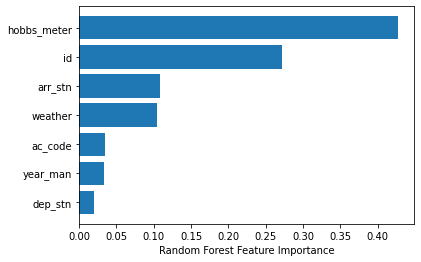

In [ ]:
sorted_idx = rf_cv.best_estimator_.feature_importances_.argsort()
plt.barh(rf_cv.best_estimator_.feature_names_in_[sorted_idx], rf_cv.best_estimator_.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")